# Data Simulation

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of AI for Health (AIH), Talavera-López Lab
- **Date of Creation:** 24.05.2024
- **Date of Last Modification:** 02.07.2024

## 1. Setup

### 1.1 Import Libraries

In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import os
import warnings

import numpy as np
import pandas as pd
import pickle
import random
import scanpy as sc
import squidpy as sq

from nichecompass.utils import (extract_gp_dict_from_mebocost_ms_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps)

### 1.2 Run Notebook Setup

In [48]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### 1.3 Configure Paths and Create Directories

In [49]:
species = "mouse"

ga_data_folder_path = "../../datasets/ga_data"
gp_data_folder_path = "../../datasets/gp_data"
st_data_folder_path = "../../datasets/st_data"
st_data_bronze_folder_path = st_data_folder_path + "/bronze"
st_data_silver_folder_path = st_data_folder_path + "/silver"
st_data_gold_folder_path = st_data_folder_path + "/gold"
omnipath_lr_network_file_path = f"{gp_data_folder_path}/omnipath_lr_network.csv"
nichenet_lr_network_file_path = f"{gp_data_folder_path}/nichenet_lr_network_v2_{species}.csv"
nichenet_ligand_target_matrix_file_path = f"{gp_data_folder_path}/nichenet_ligand_target_matrix_v2_{species}.csv"
mebocost_enzyme_sensor_interactions_folder_path = f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps"
gene_orthologs_mapping_file_path = f"{ga_data_folder_path}/human_mouse_gene_orthologs.csv"

## 2. Simulate Data

### 2.1 Simulate Cell-Cell Interactions (CCIs) Based on Prior Knowledge and De-novo Gene Programs (GPs)

- Here we retrieve GPs based on three databases of prior knowledge of inter- and intracellular interaction pathways:
    - OmniPath (Ligand-Receptor GPs)
    - NicheNet (Combined Interaction GPs)
    - MEBOCOST (Enzyme-Sensor GPs)
- These GPs are also used as prior GPs supplied to NicheCompass. We will artificially upregulate some GPs in the simulation data (through gene expression increments and fold changes)

In [50]:
# Retrieve OmniPath GPs (source: ligand genes; target: receptor genes)
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    species=species,
    load_from_disk=True,
    save_to_disk=False,
    lr_network_file_path=omnipath_lr_network_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=False)

In [51]:
# Retrieve NicheNet GPs (source: ligand genes; target: receptor genes, target genes)
nichenet_gp_dict = extract_gp_dict_from_nichenet_lrt_interactions(
    species=species,
    version="v2",
    load_from_disk=True,
    save_to_disk=False,
    lr_network_file_path=nichenet_lr_network_file_path,
    ligand_target_matrix_file_path=nichenet_ligand_target_matrix_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=False)

In [52]:
# Retrieve MEBOCOST GPs (source: enzyme genes; target: sensor genes)
mebocost_gp_dict = extract_gp_dict_from_mebocost_ms_interactions(
    dir_path=mebocost_enzyme_sensor_interactions_folder_path,
    species=species,
    plot_gp_gene_count_distributions=False)

In [53]:
# Filter and combine GPs
gp_dicts = [omnipath_gp_dict, nichenet_gp_dict, mebocost_gp_dict]
combined_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dicts,
    verbose=True)

print(f"Number of gene programs after filtering and combining: "
      f"{len(combined_gp_dict)}.")

Combining ACE2_ligand_receptor_GP and Ace2_ligand_receptor_target_gene_GP.
Combining ACE2_ligand_receptor_GP and L-Phenylalanine_metabolite_enzyme_sensor_GP.
Combining ADCYAP1_ligand_receptor_GP and Adcyap1_ligand_receptor_target_gene_GP.
Combining ADGRE5_ligand_receptor_GP and Adgre5_ligand_receptor_target_gene_GP.
Combining ADIPOQ_ligand_receptor_GP and Adipoq_ligand_receptor_target_gene_GP.
Combining ADM_ligand_receptor_GP and Adm_ligand_receptor_target_gene_GP.
Combining ADM2_ligand_receptor_GP and Adm2_ligand_receptor_target_gene_GP.
Combining AGRP_ligand_receptor_GP and Agrp_ligand_receptor_target_gene_GP.
Combining AGT_ligand_receptor_GP and Agt_ligand_receptor_target_gene_GP.
Combining ALCAM_ligand_receptor_GP and Alcam_ligand_receptor_target_gene_GP.
Combining ALKAL1_ligand_receptor_GP and Alkal1_ligand_receptor_target_gene_GP.
Combining ALKAL2_ligand_receptor_GP and Alkal2_ligand_receptor_target_gene_GP.
Combining AMBN_ligand_receptor_GP and Ambn_ligand_receptor_target_gene_G

In [85]:
### Simulate prior knowledge CCIs ###
# Create region cell type distribution for simulation (has to be the same as in './data_simulation.R' script)
region_celltype_arr = np.full((8, 8), 0.1)
np.fill_diagonal(region_celltype_arr, 0.7)
region_celltype_arr[0, 4:8] = 0.
region_celltype_arr[1, 4:8] = 0.
region_celltype_arr[2, 2] = 0.5
region_celltype_arr[2, 6:8] = 0.
region_celltype_arr[3, 3] = 0.5
region_celltype_arr[3, 6:8] = 0.
region_celltype_arr[4, 0:4] = 0.
region_celltype_arr[4, 4] = 1.
region_celltype_arr[4, 5] = 0.
region_celltype_arr[4, 6] = 0.
region_celltype_arr[4, 7] = 0.
region_celltype_arr[5, 0:5] = 0.
region_celltype_arr[5, 5] = 1.
region_celltype_arr[5, 6] = 0.
region_celltype_arr[5, 7] = 0.
region_celltype_arr[6, :] = 0.125
region_celltype_arr[7, 0:4] = 0.
region_celltype_arr[7, 4:8] = 0.25
print(region_celltype_arr)

np.random.seed(42)

combined_gp_df = pd.DataFrame(combined_gp_dict.values(), index=combined_gp_dict.keys())
print(len(combined_gp_df)) # 1582

combined_gp_df.reset_index(inplace=True)
combined_gp_df["gp"] = combined_gp_df["index"]
combined_gp_df.drop("index", axis=1, inplace=True)

# Get unique number of genes in combined gps
combined_gp_source_genes = combined_gp_df["sources"]
combined_gp_target_genes = combined_gp_df["targets"]
unique_target_genes = set([gene for genes in combined_gp_target_genes for gene in genes])
print(len(unique_target_genes)) # 19517
unique_source_genes = set([gene for genes in combined_gp_source_genes for gene in genes])
print(len(unique_source_genes)) # 2389
unique_all_genes = unique_target_genes | unique_source_genes
print(len(unique_all_genes)) # 20306
target_but_not_source_genes = unique_target_genes - unique_source_genes

# Sample first cell type and region
sampled_idx = np.random.choice([n for n in range(1,9)], size=len(combined_gp_df))

# Sample second cell type according to region cell type distributions
sampled_idx_2 = []
for idx in sampled_idx:
    idx_2 = np.random.choice([n for n in range(1,9)],
                             p=region_celltype_arr[idx-1])
    sampled_idx_2.append(idx_2)
sampled_idx_2 = np.array(sampled_idx_2)

# Sample max 10 source and target genes
np.random.seed(41)
combined_gp_df["celltypeA"] = ["Celltype" + str(idx) for idx in sampled_idx]
combined_gp_df["regionA"] = ["Region" + str(idx) for idx in sampled_idx]
combined_gp_df["celltypeB"] = ["Celltype" + str(idx) for idx in sampled_idx_2]
combined_gp_df["sources"] = combined_gp_df["sources"].apply(lambda x: np.random.choice(sorted(x), size=min(10, len(x)), replace=False)) # only keep max 10 source genes
combined_gp_df["targets"] = combined_gp_df["targets"].apply(lambda x: np.random.choice(sorted(x), size=min(10, len(x)), replace=False)) # only keep max 10 target genes
combined_gp_df["sources"] = combined_gp_df["sources"].apply(lambda x: ",".join(map(str, x)))
combined_gp_df["targets"] = combined_gp_df["targets"].apply(lambda x: ",".join(map(str, x)))
combined_gp_df.drop(["sources_categories", "targets_categories"], axis=1, inplace=True)

### Simulate de-novo CCIs such that total number of GPs is matched between prior and de-novo GPs ###
np.random.seed(40)

n_denovo_gps = len(combined_gp_df)
de_novo_gp_df = pd.DataFrame({
    "sources": [np.random.choice(sorted(target_but_not_source_genes), 1) for i in range(n_denovo_gps)],
    "targets": [np.random.choice(sorted(unique_all_genes), 10, replace=False) for i in range(n_denovo_gps)]})
de_novo_gp_df["sources"] = de_novo_gp_df["sources"].apply(lambda x: ",".join(map(str, x)))
de_novo_gp_df["targets"] = de_novo_gp_df["targets"].apply(lambda x: ",".join(map(str, x)))
de_novo_gp_df["gp"] = de_novo_gp_df["sources"].apply(lambda x: f"Add-On_{x}_GP")

# Sample first cell type and region
sampled_idx_3 = np.random.choice([n for n in range(1,9)], size=len(de_novo_gp_df))

# Sample second cell type according to region cell type distributions
sampled_idx_4 = []
for idx in sampled_idx_3:
    idx_4 = np.random.choice([n for n in range(1,9)],
                             p=region_celltype_arr[idx-1])
    sampled_idx_4.append(idx_4)
sampled_idx_4 = np.array(sampled_idx_4)

de_novo_gp_df["celltypeA"] = ["Celltype" + str(idx) for idx in sampled_idx_3]
de_novo_gp_df["regionA"] = ["Region" + str(idx) for idx in sampled_idx_3]
de_novo_gp_df["celltypeB"] = ["Celltype" + str(idx) for idx in sampled_idx_4]
all_gp_df = pd.concat([combined_gp_df, de_novo_gp_df]).reset_index(drop=True)
print(len(all_gp_df)) # 3164

# Get unique number of genes (for full gene panel simulation)
all_gp_source_genes = all_gp_df["sources"].apply(lambda x: x.split(",")).values
all_gp_target_genes = all_gp_df["targets"].apply(lambda x: x.split(",")).values
unique_target_genes = set([gene for genes in all_gp_target_genes for gene in genes])
unique_source_genes = set([gene for genes in all_gp_source_genes for gene in genes])
unique_all_genes = unique_target_genes | unique_source_genes
print(len(unique_all_genes)) # 13993

np.random.seed(42)

# Filter for limited gene panel simulation
all_gp_df_filtered = all_gp_df.iloc[np.random.choice(all_gp_df.index, size=100, replace=False)]

# Get unique number of genes for limited gene panel simulation
all_gp_filtered_source_genes = all_gp_df_filtered["sources"].apply(lambda x: x.split(",")).values
all_gp_filtered_target_genes = all_gp_df_filtered["targets"].apply(lambda x: x.split(",")).values
unique_filtered_target_genes = set([gene for genes in all_gp_filtered_target_genes for gene in genes])
unique_filtered_source_genes = set([gene for genes in all_gp_filtered_source_genes for gene in genes])
unique_filtered_all_genes = unique_filtered_target_genes | unique_filtered_source_genes
print(len(unique_filtered_all_genes)) # 951

[[0.7   0.1   0.1   0.1   0.    0.    0.    0.   ]
 [0.1   0.7   0.1   0.1   0.    0.    0.    0.   ]
 [0.1   0.1   0.5   0.1   0.1   0.1   0.    0.   ]
 [0.1   0.1   0.1   0.5   0.1   0.1   0.    0.   ]
 [0.    0.    0.    0.    1.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.    0.    0.    0.    0.25  0.25  0.25  0.25 ]]
1582
19517
2389
20306
3164
13993
951


In [91]:
### Create different GP increment parameters ###
np.random.seed(40)

increment_params = [1, 3, 5, 8]

for increment_mode, increment_probs in zip(
    ["strong", "weak"],
    [[0.5, 1/6, 1/6, 1/6], # 50% of GPs (~6997) with increment
     [0.9, 1/30, 1/30, 1/30]]): # 10% of GPs (~1399) with increment
    all_gp_df["increment_param"] = np.random.choice(increment_params, size=len(all_gp_df), p=increment_probs)
    all_gp_df.to_csv(f"{gp_data_folder_path}/data_simulation/sim_gps_{increment_mode}increments.csv", index=False)
    all_gp_agg_df = all_gp_df.groupby(["regionA", "increment_param"]).agg(set)
    all_gp_agg_df = all_gp_agg_df.applymap(lambda x: ','.join(map(str, x)) if isinstance(x, set) else x)
    all_gp_agg_df.to_csv(
        f"{gp_data_folder_path}/data_simulation/sim_gps_stats_{increment_mode}increments.csv")

    all_gp_df_filtered["increment_param"] = np.random.choice(increment_params, size=len(all_gp_df_filtered), p=increment_probs)
    all_gp_df_filtered.to_csv(f"{gp_data_folder_path}/data_simulation/sim_gps_filtered_{increment_mode}increments.csv", index=False)
    all_gp_filtered_agg_df = all_gp_df_filtered.groupby(["regionA", "increment_param"]).agg(set)
    all_gp_filtered_agg_df = all_gp_filtered_agg_df.applymap(lambda x: ','.join(map(str, x)) if isinstance(x, set) else x)
    all_gp_filtered_agg_df.to_csv(
        f"{gp_data_folder_path}/data_simulation/sim_gps_filtered_stats_{increment_mode}increments.csv")

### 2.2 Simulate Gene Expression Data Based on Simulated Cell-Cell Interactions

Run './data_simulation.R' script with simulated GP-based CCIs as input.

In [58]:
sim_names = [#"sim_ref_951genes_10000locs_strongincrements",
             "sim_ref_951genes_100locs_strongincrements"
]

In [59]:
for sim_name in sim_names:
    adata = sc.read_h5ad(f"{st_data_silver_folder_path}/{sim_name}/{sim_name}.h5ad")
    
    adata.obs["cell_types"] = adata.obs["cell_type"]
    del(adata.obs["cell_type"])
    adata.obs["niche_types"] = adata.obs["region_label"]
    del(adata.obs["region_label"])
    adata.obsm["spatial"] = np.array(adata.obs[["x", "y"]] * 0.35) # this is set to achieve an average number of neighbors of around 6 (similar to Nanostring CosMx Human Brain data)
    del(adata.obs["x"])
    del(adata.obs["y"])
    adata.layers["counts"] = adata.X.astype(np.float32)
    adata.obs["batch"] = "batch1"
    
    os.makedirs(f"{st_data_gold_folder_path}/{sim_name}", exist_ok=True)
    adata.write(f"{st_data_gold_folder_path}/{sim_name}/{sim_name}.h5ad")

### 2.3 Explore Simulated Data

In [79]:
increment_mode = "strong" # "weak", "strong"
n_genes = 951
sim_name = f"sim_ref_{n_genes}genes_100locs_{increment_mode}increments"

In [61]:
adata = sc.read_h5ad(f"{st_data_gold_folder_path}/{sim_name}/{sim_name}.h5ad")

In [62]:
# Compute PCA and UMAP
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

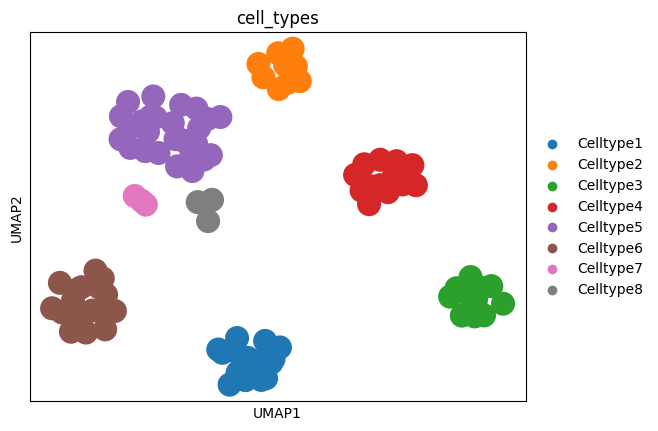

In [63]:
# Visualize cell types in UMAP PCA-reduced gene expression space
sc.pl.umap(adata, color=["cell_types"])

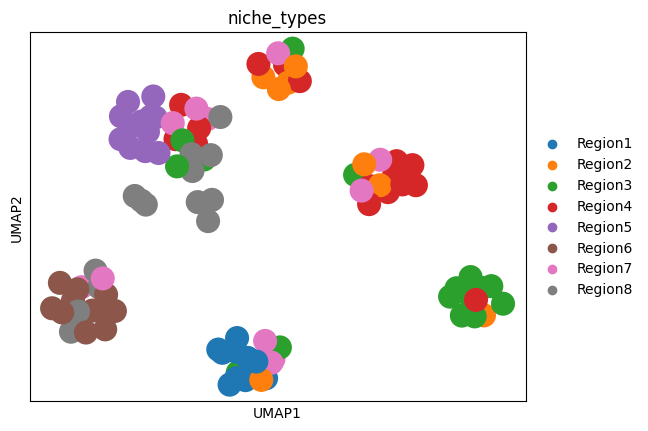

In [64]:
# Visualize niche types in UMAP PCA-reduced gene expression space
sc.pl.umap(adata, color=["niche_types"])

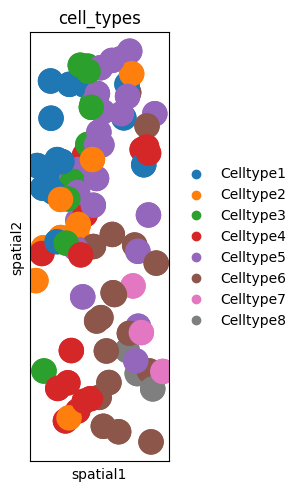

In [65]:
# Visualize cell types in tissue
sq.pl.spatial_scatter(adata, color="cell_types", shape=None) 

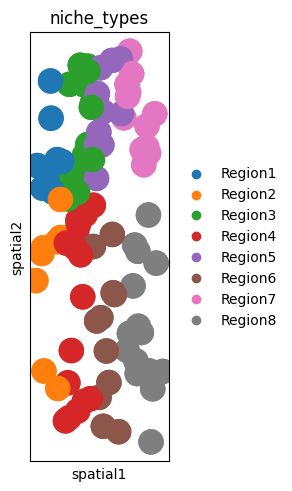

In [66]:
# Visualize niche types in tissue
sq.pl.spatial_scatter(adata, color="niche_types", shape=None) 

In [80]:
all_gp_df = pd.read_csv(f"{gp_data_folder_path}/data_simulation/sim_gps{'_filtered' if n_genes == 951 else ''}_{increment_mode}increments.csv")

In [81]:
increment_param = 8
cell_type_A = "Celltype5"
cell_type_B = "Celltype5"

all_gp_df["sources_adata"] = all_gp_df["sources"].apply(lambda x: [gene for gene in x.split(",") if gene in adata.var_names])
all_gp_df["targets_adata"] = all_gp_df["targets"].apply(lambda x: [gene for gene in x.split(",") if gene in adata.var_names])
all_gp_df[(all_gp_df["increment_param"] == increment_param) &
          ((all_gp_df["sources_adata"].apply(lambda x: len(x)) != 0) |
           (all_gp_df["targets_adata"].apply(lambda x: len(x)) != 0)) &
          (all_gp_df["celltypeA"] == cell_type_A) &
          (all_gp_df["celltypeB"] == cell_type_B)]

,sources,targets,gp,celltypeA,regionA,celltypeB,increment_param,sources_adata,targets_adata
79,Arid5b,"Irs1,Ephb1,Catsper1,AREL1,Smarca1,Slc7a1,Aspsc...",Add-On_Arid5b_GP,Celltype5,Region5,Celltype5,8,[Arid5b],"[Irs1, Ephb1, Catsper1, AREL1, Smarca1, Slc7a1..."


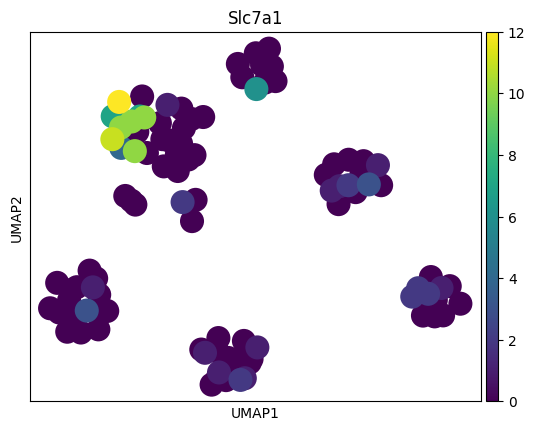

In [82]:
# Visualize incremented genes in UMAP PCA-reduced gene expression space
sc.pl.umap(adata, color=["Slc7a1"], layer="counts")

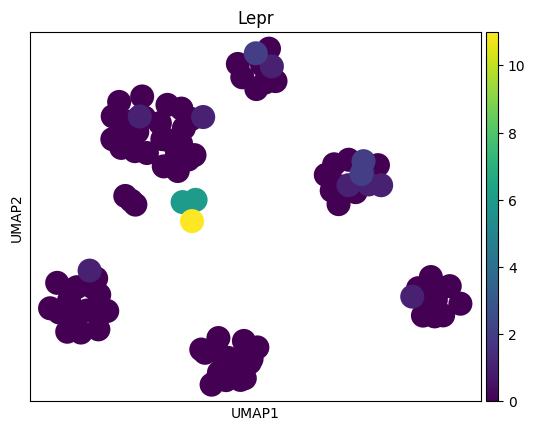

In [83]:
sc.pl.umap(adata, color=["Lepr"], layer="counts")